### Wholesale customers Data

In [1]:
import numpy as np  # 線形代数ライブラリー
import pandas as pd  # データの加工, CSVファイルの読み書き
from pandas import scatter_matrix
import matplotlib.pyplot as plt  # 描画ライブラリー

import seaborn as sns  # 描画スタイル変更ライブラリ
%matplotlib inline
from sklearn.model_selection import train_test_split

data = pd.read_csv('/Users/andoutakaaki/DIC_study/Sprint6/Wholesale customers data.csv') # csvファイルの読み込み
data.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  


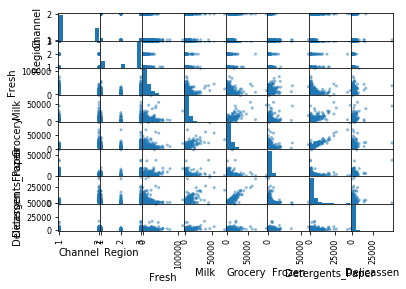

In [2]:
# 散布図行列
scatter_matrix(data)
plt.show()

In [3]:
data.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [4]:
# 2変数をドロップする
new_data = data.drop(['Channel', 'Region'], axis=1)

### 対数変換によるスケーリングを行う

In [5]:
from scipy import stats
from scipy.stats import norm, skew #for some statistics

numeric_feats = new_data.dtypes[new_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = new_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(15)



Skew in numerical features: 



,Skew
Delicassen,11.113534
Frozen,5.887826
Milk,4.039922
Detergents_Paper,3.619458
Grocery,3.575187
Fresh,2.552583


In [6]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #new_data[feat] += 1
    new_data[feat] = boxcox1p(new_data[feat], lam)

There are 6 skewed numerical features to Box Cox transform


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  """Entry point for launching an IPython kernel.


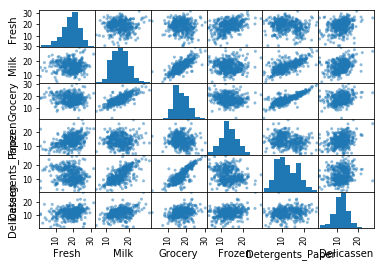

In [7]:
scatter_matrix(new_data)
plt.show()

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)     # 可視化するためにPCAで特徴量を2個に減らす
pca = pca.fit(new_data)
data_pca = pca.transform(new_data)

In [9]:
data_pca.shape

(440, 2)

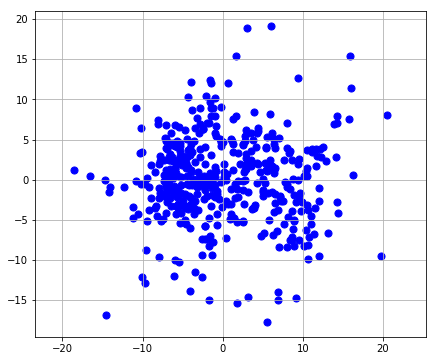

In [10]:
# 描画してみる
plt.figure(figsize=(7, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='b', marker='o', s=50)
plt.axis('equal')
plt.grid()
plt.show()

In [11]:
label = np.random.randint(0,4,440)   # 初期のラベルを作る

In [12]:
# K-meansのクラス
class ScratchKMeans:
    
    def __init__(self, cluster, iteration):
        self.iteration = iteration
        self.cluster = cluster
    
    # 中心点表を作成する関数
    def _get_center_point(self, X):
        
        # 中心点表を初期化する
        self.center_point_list = []

        for i in np.unique(self.label):

            # X0軸方向の平均
            X0_sum = X[self.label == i][:, 0].sum()
            X0_cnt = len(X[self.label == i])
            X0_point = X0_sum / X0_cnt

            # X1軸方向の平均
            X1_sum = X[self.label == i][:, 1].sum()
            X1_cnt = len(X[self.label == i])
            X1_point = X1_sum / X1_cnt

            # 中心点（重心）を求める
            center_point = [X0_point, X1_point]

            # 中心点表を作成する
            self.center_point_list.append(center_point)
            #print(self.center_point_list[1:])
    
    # 中心点と全データとの距離を求める関数
    def _get_distance(self, X):
        self._get_center_point(X)
        distance_list = np.zeros((len(X), len(self.center_point_list)))
        #print(distance_list)

        for i, values in enumerate(self.center_point_list):

            # 重心と全データとの距離を取得する
            for j in range(len(X)):
                
                # 2列目、３列目だけをとる
                diff = values - X[j]
                distance = np.linalg.norm(diff)
                distance_list[j, i] = distance
                #print(distance_list)
        
        return distance_list
    
    # 全データの一番近いクラスタラベルをゲット出来た
    def fit(self, X):
        # なので、新しいクラスラベルの値へ、古いクラスラベルを更新してあげる
        for i in range(self.iteration):
            
            # 距離表で、それぞれのXで最初のクラスラベルのインデックスを取得
            # そのインデックスは、クラスタラベルに等しい
            self.label = np.argmin(self._get_distance(X), axis=1)
            
            # 今時点の中心点を保持しておく
            pre_center_point_list = self.center_point_list
            
            # クラスタラベルを最新
            self.label = np.argmin(self._get_distance(X), axis=1)
            
            # 前後で中心点を比較
            if pre_center_point_list == self.center_point_list:
                #print("---学習終了しました---",i*2,"イテレーション回数")
                break
    
    # エルボー法 誤差平方和SSE
    # 重心座標はfitで取得出来ているので、それを使って、
    # クラスタ数が変化した時のSSEの変化度を取得する関数
    def elbow(self, X, cluster):
        self.cluster = cluster
        self.label = np.random.randint(0, self.cluster, len(X))
        
        # SSE_list
        sse_list = []
        
        # クラスタ数をパラメータとしてfitさせる
        for n in range(self.cluster):
            
            self.cluster = n + 1
            
            # クラスタラベルを作成
            self.label = np.random.randint(0, self.cluster, len(X))
            
            # 学習
            self.fit(X)
        
            # |Xn - μk||**2の枠を作成
            elbow_list = np.zeros((len(X), len(self.center_point_list)))
            
            for i, values in enumerate(self.center_point_list):

                # ||Xn - μk||**2の表を作成する
                for j in range(len(X)):    
                    elbow_diff = X[j] - values
                    
                    # ドット積でやり方
                    #elbow_list[j, i] = np.dot(elbow_diff, elbow_diff.T)
                    
                    # ノルムを取って二乗するやり方
                    elbow_list[j, i] = np.linalg.norm(elbow_diff)**2

            # 最小値を取得
            elbow_list_min = elbow_list.min(axis=1)

            # SSEを算出
            sse = elbow_list_min.sum()
            sse_list.append(sse)
            
        return sse_list

In [13]:
skm3 = ScratchKMeans(cluster=4, iteration = 10)
skm3.elbow(data_pca, 20)
sse3 = skm3.elbow(data_pca, 20)

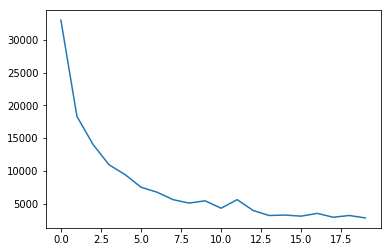

In [14]:
plt.plot(range(0,20), sse3)
plt.show()

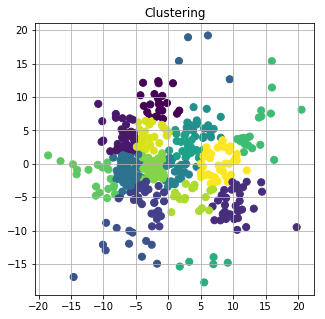

In [17]:
plt.figure(figsize =(5,5))
plt.title('Clustering')
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=skm3.label , marker='o', s=50)
plt.grid()


### クラスタリングとは何か
クラスタリングは、データを自然なまとまりに分ける手法です。このまとまりのことをクラスタ(cluster)と呼びます。クラスタとは日本語で言えば群れ、集団、房といった意味です。グループとも言いかえられます。データ（サンプルとも呼びます）を似ているものは同じクラスタ、違うものは別のクラスタに分けていきます。このとき正解は存在せず、あくまでそのデータの関係だけを見て判断します。

### K-meansとは何か
k-means（k-平均法）はクラスタリングの手法の中で最も代表的なものです。
クラスタの平均の値を考えながら、指定したk個のクラスタに分類するためにこのような名前がついています。
クラスタリングの中でも非階層的手法と呼ばれるもののひとつです。

### クラスタ分析について
クラスタリングの代表的手法であるk-meansは非階層的手法と呼ばれるものです。k-meansは実用上は圧倒的に著名ですが、別のクラスタ分析には凝集型があり、凝集型の方が単純かつ自然な方法であり、樹状図を描き可視化できるという利点は見逃せません。

### 中心点の初期値についてランダム以外にはどのようなものがあるか
初期のクラスタ中心として，最も離れているデータ同士をクラスタ中心の初期値として選択する手法などがあリます。

### クラスタ数の決め方について
完璧なクラスタ数の決め方は存在しない。「エルボー法」と「シルエット分析」で適切なクラスター数を検討して決める。